In [1]:
using Pkg
Pkg.activate("/home/users/shubhgup/Codes/Julia/TISExperiments.jl")

  Activating environment at `~/Codes/Julia/TISExperiments.jl/Project.toml`


In [2]:
using Revise

In [3]:
using POMDPs, POMDPGym, POMDPSimulators, POMDPPolicies, Distributions
using BSON
using SARSOP, Random
using POMCPOW
using BeliefUpdaters
using ParticleFilters
using FileIO
using TISExperiments
using POMDPGifs
using D3Trees
# using Interact
using TreeImportanceSampling
include("lander_pomdp.jl")

┌ Info: Precompiling TISExperiments [9371d7c3-8469-4c28-bc82-5ae8ba277c16]
└ @ Base loading.jl:1342


In [4]:
# using WebIO
# WebIO.install_jupyter_nbextension()
# using Conda
# Conda.pip_interop(true)
# Conda.pip("install", "webio_jupyter_extension")

In [5]:
using Plots
using ProgressMeter

In [6]:
Random.seed!(42)
pomdp = LunarLander()

LunarLander(0.5, 1.0, 10.0, [0.0, 0.0, 0.0, 0.1, 0.1, 0.01], [1.0, 0.01, 0.1])

In [7]:
solver = POMCPOWSolver(criterion=MaxUCB(20.0))

policy = POMDPs.solve(solver, pomdp);

In [8]:
dt = 0.1; # Do not change
maxT = 2.0; # Do not change

In [9]:
function init_particle_belief(pomdp)
    dist = POMDPs.initialstate_distribution(pomdp)
    return ParticleCollection([rand(dist) for i=1:50])
end

init_particle_belief (generic function with 1 method)

In [10]:
costfn(x) = get_cost(x[1][2], x[2], x[3]; dt=dt)

costfn (generic function with 1 method)

In [11]:
amdp = RPOMDP(pomdp=pomdp, π=policy, updater=BootstrapFilter(pomdp, 50), initial_belief_distribution = init_particle_belief(pomdp), cost_fn=costfn, dt=dt, maxT=maxT)

RPOMDP{Vector{Float64}, Vector{Float64}, Vector{Float64}}
  pomdp: LunarLander
  π: POMCPOWPlanner{LunarLander, POMCPOW.POWNodeFilter, MaxUCB, MCTS.RandomActionGenerator{Random._GLOBAL_RNG}, BasicPOMCP.SolvedPORollout{RandomPolicy{Random._GLOBAL_RNG, LunarLander, NothingUpdater}, NothingUpdater, Random._GLOBAL_RNG}, Int64, Float64, POMCPOWSolver{Random._GLOBAL_RNG, POMCPOW.var"#6#12"}}
  updater: BasicParticleFilter{LunarLander, LunarLander, LowVarianceResampler, Random._GLOBAL_RNG, Vector{Vector{Float64}}}
  initial_belief_distribution: ParticleCollection{Vector{Float64}}
  cost_fn: costfn (function of type typeof(costfn))
  dt: Float64 0.1
  maxT: Float64 2.0


In [12]:
POMDPs.observation(pomdp::LunarLander, a, s) = get_observation(s, a)
POMDPs.observation(pomdp::LunarLander, a, s, x) = get_observation_noisy(s, a, x)

POMDPs.actions(mdp::RPOMDP, s) = disturbance(mdp, s)

In [13]:
# Assumes implemented noise-control version of observation `POMDPs.observation(pomdp, a, s, x)`

function POMDPs.gen(mdp::RPOMDP, st, x, rng::AbstractRNG = Random.GLOBAL_RNG; kwargs...)
    t, s, b = st
    
    try
        a = action(mdp.π, b)
        sp, r = @gen(:sp,:r)(mdp.pomdp, s, a, rng)
        o = POMDPs.observation(pomdp, a, sp, x)

        cost = mdp.cost_fn((;st, a, sp, o, r)) # Rmax - r

        b = update(mdp.updater, b, a, o)
        
        return (sp=Any[t+mdp.dt, sp, b], r=cost)
    catch e
#         println("Forcing termination")
        
        t = mdp.maxT
        a = rand(actions(mdp, s))
        sp, r = @gen(:sp,:r)(mdp.pomdp, s, a, rng)
        o = POMDPs.observation(pomdp, a, sp, x)
        cost = mdp.cost_fn((;st, a, sp, o, r))
        
        return (sp=Any[t+mdp.dt, sp, b], r=cost)
    end
end

In [14]:
function POMDPModelTools.render(pomdp::LunarLander, step)
    p = plot(xlim = (0, 10))
    for i=1:6
        scatter!([step.t], [step.s[2][i]], label="state $(i)")
    end
    p
end

POMDPModelTools.render(mdp::RPOMDP, step) = POMDPModelTools.render(mdp.pomdp, step)

In [15]:
function disturbance(m::typeof(amdp), s)
    x_z = [0.0, 20]
    x_ω = [0.0, 0.2]
    x_x = [0.0, 2]
    σz = 5.0
    σω = 0.05
    σx = 0.5
    p_z = [pdf(Normal(0.0, σz), x) for x in x_z]
    p_ω = [pdf(Normal(0.0, σω), x) for x in x_ω]
    p_x = [pdf(Normal(0.0, σx), x) for x in x_x]
    
    xs = [Iterators.product(x_z, x_ω, x_x)...]
    xs = [[x...] for x in xs]
    ps = [Iterators.product(p_z, p_ω, p_x)...]
    ps = [prod(p) for p in ps]
#     ps = ones(length(xs))
    ps ./= sum(ps)
    px = GenericDiscreteNonParametric(xs, ps)
    return px
end

disturbance (generic function with 1 method)

In [16]:
fixed_s = rand(initialstate(amdp));

In [17]:
actions(amdp, fixed_s)

GenericDiscreteNonParametric([[0.0, 0.0, 0.0], [20.0, 0.0, 0.0], [0.0, 0.2, 0.0], [20.0, 0.2, 0.0], [0.0, 0.0, 2.0], [20.0, 0.0, 2.0], [0.0, 0.2, 2.0], [20.0, 0.2, 2.0]], DiscreteNonParametric{Int64, Float64, Vector{Int64}, Vector{Float64}}(
support: [1, 2, 3, 4, 5, 6, 7, 8]
p: [0.9989942869500168, 0.00033512524875984863, 0.0003351252487598486, 1.1242199662546183e-7, 0.00033512524875984863, 1.1242199662546183e-7, 1.1242199662546182e-7, 3.771337842202475e-11]
)
)

In [20]:
# N = 1000
N = 10_000
c = 0.0
α = 0.01

β = 0.01
γ = 0.01

schedule = 1.0 # set to Inf to switch off

uniform_floor = 1e-6 # set to 0.0 to switch off

baseline = false
base_continue = true
if base_continue
    baseline_costs = load("$(path)_baseline_$(N).jld2")["risks"]
else
    baseline_costs = []
end


path = "data/lander";

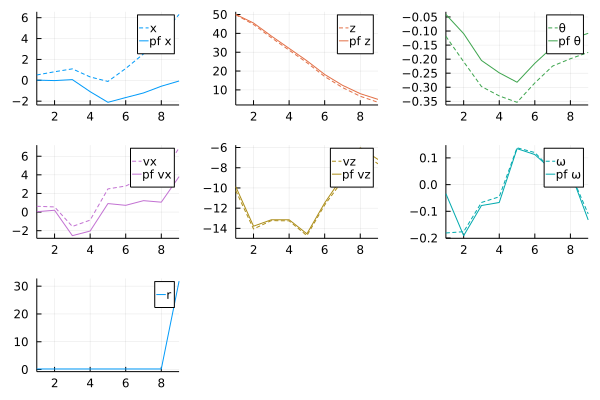

In [19]:
function plot_path(history)
    state_l = hcat([step.s[2] for step in history]...)
    pf_state_l = hcat([mean(step.s[3]) for step in history]...)
    costs_l = [step.r for step in history]
    labels = ['x', 'z', 'θ', "vx", "vz", 'ω']
    plots = []
    for i=1:6
        p = plot(xlim = (1, length(history)))
        plot!(state_l[i, :], label=labels[i], linestyle=:dash, color=i)
        plot!(pf_state_l[i, :], label="pf $(labels[i])", color=i)
        push!(plots, p)
    end
    p = plot(xlim = (1, length(history)))
    plot!(costs_l, label="r")
    push!(plots, p)
    
    plot(plots...)
end

# history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(disturbance(amdp, s))), fixed_s);
history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> [0.0, 0.0, 0.0]), fixed_s);
plot_path(history)

In [521]:

@showprogress for i=1:N
    cost = sum(collect(simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(disturbance(amdp, s))), fixed_s)[:r]))
#     cost = sum(collect(simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> a), fixed_s)[:r]))
    push!(baseline_costs, cost)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:16


In [65]:
# p = histogram(plot_costs[1][2], label="$(plot_costs[1][1])", alpha=0.4, bins=100)
# for x in plot_costs[end:end]
#     histogram!(x[2], label="$(x[1])", alpha=0.4, bins=100)
# end
# p

In [102]:
# print("Starting grid search...")
# mc_samps = load("data/gridworld_baseline_10000000.jld2")["risks"]
# mc_samps = [Float64(samp) for samp in mc_samps]

# TISExperiments.run_grid_search(amdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path)
# TISExperiments.run_grid_search(amdp, tree_mdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path; N_l=[1_000_000], save_every=1)
# TISExperiments.run_grid_search(amdp, tree_mdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path; N_l=[10_000], α_l=[1e-2], β_a_l=[0.5], β_b_l=[0.3], schedule_l = [0.1])

# print("...Completed.")


# results_baseline, results_tis, planner = TISExperiments.run_baseline_and_treeIS(amdp, fixed_s, disturbance; N, c, α, β, γ, schedule, uniform_floor, baseline)

tree_mdp = construct_tree_amdp(amdp, disturbance; reduction="sum")
planner = TreeImportanceSampling.mcts_isdpw(tree_mdp; N=500, c, α)
tree_fixed_s = TreeImportanceSampling.TreeState(fixed_s);

In [106]:
a, info = action_info(planner, tree_fixed_s; tree_in_info=true, N=500, c, α, β, γ, schedule, uniform_floor, baseline)
tis_output = (planner.mdp.costs, [], planner.mdp.IS_weights, info[:tree]);

"$(strategy_text) strategy" = "Naive strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


In [41]:
# planner.tree.cdf_est
# planner.tree.total_n
# planner.mdp.costs

In [42]:
# D3Tree(planner.tree.dpw_tree)

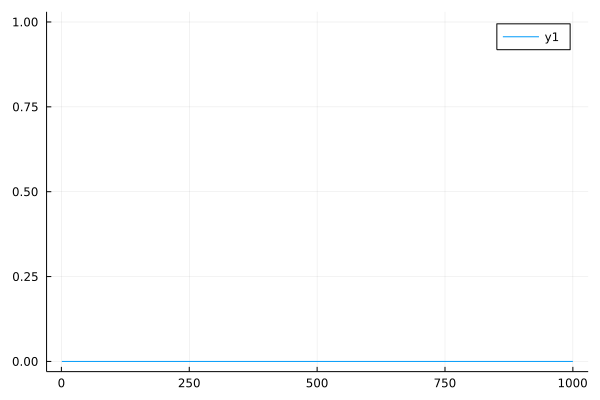

In [87]:
plot(planner.mdp.IS_weights)

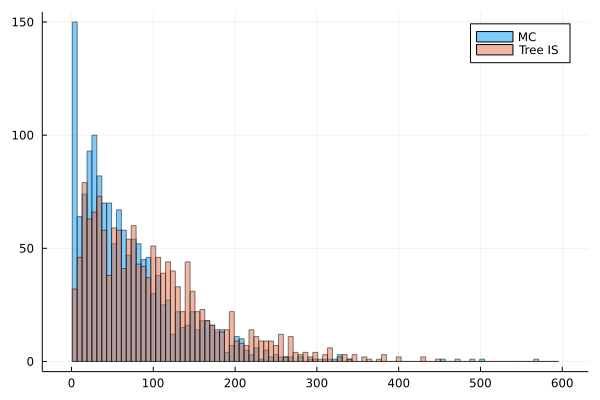

In [107]:
tis_range = (1, length(tis_output[1]))
histogram(baseline_costs[tis_range[1]:tis_range[2]], alpha=0.5, label="MC", bins=1:6:600)
histogram!(planner.mdp.costs[tis_range[1]:tis_range[2]], alpha=0.5, label="Tree IS", bins=1:6:600)

In [523]:

# print("Baseline metrics")

# TISExperiments.evaluate_metrics(baseline_costs; alpha_list=[1e-3])

# print("\nTIS metrics: N=$(N), c=$(c), α=$(α), β=$(β)), γ=$(γ)")

# TISExperiments.evaluate_metrics(tis_output[1][tis_range[1]:tis_range[2]]; weights=exp.(tis_output[3][tis_range[1]:tis_range[2]]), alpha_list=[1e-3])

# if baseline
# save("$(path)_baseline_$(N).jld2", Dict("risks" => baseline_costs, "states" => []))
# # else
# #     save("$(path)_mcts_IS_$(N).jld2", Dict("risks" => results_tis[1], "states" => results_tis[2], "IS_weights" => results_tis[3], "tree" => results_tis[4]))
# # end

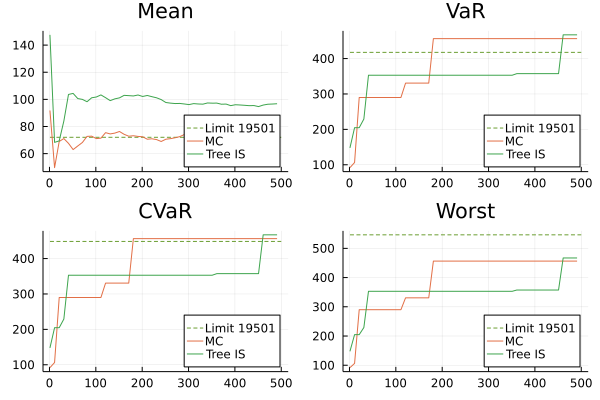

In [92]:
TISExperiments.plot_metrics([baseline_costs, baseline_costs, tis_output[1]]; weights_l=[nothing, nothing, exp.(tis_output[3])], range_l = tis_range, alpha=1e-3, names=["Limit", "MC", "Tree IS"], N_list = [2^i for i=1:10])

LoadError: UndefVarError: plot not defined